# Парсинг вакансий с LinkedIn

**Цели:**

1. Распарсить вакансии LinkedIn с помощью BS 4 и Selenium, создав следующие признаки:

- наименование вакансии;
- город;
- страна;
- тип занятости (online, hybride, on-site);
- компания;
- размер компании (количество работников);
- сфера деятельности компании;
- требуемые хард скилы;
- дата публикации вакансии;
- количество кандидатов на вакансию.

2. Подготовить данных к визуализации:

- фильтрация датафрейма с оставлением только вакансий для data scientist'ов;
- удаление дубликатов;
- удаление ненужных атрибутов (признаков).

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import re
import os
from dotenv import load_dotenv
from ast import literal_eval

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

Перечень скилов.

In [2]:
skills_list = [
    ' ai ', ' cv ', ' ml ', ' r ', 'a/b testing', 'actian', 'adobe analytics', 'airflow',
    'alooma', 'alteryx', 'apache camel', 'apache nifi', 'apache spark', 'api', 'asana',
    'aws', 'aws glue', 'azure', 'azure data factory', 'basecamp', 'bigquery', 'birst',
    'blendo', 'bootstrap', 'c#', 'c++', 'cdata sync', 'cognos', 'computer vision', 'css',
    'dashboard', 'data studio', 'databricks', 'dataddo', 'datahub', 'dataiku', 'datastage',
    'dbconvert', 'dbeaver', 'deep learning', 'dl/ml', 'docker', 'domo', 'erwin', 'etleap',
    'excel', 'fivetran', 'gcp', 'github', 'gitlab', 'google analytics', 'google data flow',
    'grafana', 'hadoop', 'hana', 'hive', 'html', 'ibm coremetrics', 'inetsoft', 'informatica',
    'integrate.io', 'iri voracity', 'izenda', 'java', 'java script', 'jenkins', 'jira', 'julia',
    'k2view', 'kantar', 'keras', 'linux', 'logstash', 'looker', 'lstm', 'luidgi', 'matillion',
    'matlab', 'metabase', 'microsoft sql', 'microstrategy', 'miro', 'ml flow',
    'natural nanguage processing', 'nlp', 'omniture', 'oracle business intelligence',
    'oracle data integrator', 'panorama', 'pentaho', 'postgresql', 'power bi', 'power point',
    'python', 'pytorchhevo data', 'qlik sense', 'qlikview', 'querysurge', 'rapidminer', 'redash',
    'redshift', 'rivery', 'salesforce', 'sap business objects', 'sas', 'sas visual analytics',
    'scala', 'selenium', 'singer', 'sisense', 'skyvia', 'snowflake', 'spark', 'spotfire', 'spss',
    'sql', 'ssis', 'statistics', 'statsbot', 'stitch', 'streamsets', 'tableau', 'talend', 'targit',
    'tensorflow', 'thoughtspot', 'timeseries', 'trello', 'vba', 'webfocus', 'wfh', 'xplenty', 'yellowfin']

Функция BeautifulSoup парсинг данных.

In [3]:
def parsing(job_item):    
    # applicants и description всегда не nan.
    for _ in range(3):
        try:
            description = WebDriverWait(driver, 5) \
                .until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'article'))) \
                .text.replace('\n', ' ').replace('\r', '').strip()
            
            soup = BeautifulSoup(driver.page_source)
            applicants = int(
                re.findall(r'\d{1,3}', str(soup.findAll('span', class_='jobs-unified-top-card__bullet')))[0]
            )
            break
        except:
            time.sleep(1.5)
    
    # Список skills_list преобразуем к виду 'a|b|c d|e', специальные символы обрабатываем re.escape.
    skills = set(re.findall(f'({"|".join(map(re.escape, skills_list))})',
                            description.lower()))
            
    # Проверка - задана ли переменная applicants.
    if 'applicants' not in vars():
        applicants = 0
    
    # Время размещения вакансии.
    try:
        placement_date = job_item.find_element(By.TAG_NAME, 'time').get_attribute('datetime')
    except:
        # Для Promoted приравниваем время текущему.
        placement_date = time.strftime("%Y-%m-%d", time.gmtime())
    
    # Название вакансии.
    title = job_item.find_element(By.CSS_SELECTOR, 'a.job-card-list__title').text.strip()

    # Ссылка на вакансию.
    link = job_item.find_element(By.CSS_SELECTOR, 'a.job-card-list__title').get_attribute('href')
       
    try:
        company = soup.find('span', class_='jobs-unified-top-card__company-name').text.strip()
    except:
        company = np.nan
    try:
        workplace_type = soup.find('span', class_='jobs-unified-top-card__workplace-type').text.strip()
    except:
        workplace_type = np.nan
            
    try:
        geo = soup.find('span', class_='jobs-unified-top-card__bullet').text.strip()
        
        if len(geo.split(',')) > 1:
            city = geo.split(',')[0].strip()
            country = geo.split(',')[-1].strip()
        elif re.findall('(metropolitan|greater|region|area)', geo, re.I) != []:
            city = re.findall(r'\b(?!metropolitan|greater|region|area)\b\w+', geo, re.I)[0]
            country = np.nan
        else:
            city = np.nan
            country = geo
    except:
        geo, city, country = np.nan, np.nan, np.nan
    
    try:
        employees = driver.find_elements(By.CSS_SELECTOR,
                                         'li.jobs-unified-top-card__job-insight')[1] \
                    .find_element(By.TAG_NAME, 'span').text

        business_activities = re.findall(r'·\s(.+)', employees)
        business_activities = business_activities[0] if business_activities != [] else np.nan
        employees = re.findall(r'\d+,?\d+', employees)
        employees = int(employees[-1].replace(',', '')) if employees != [] else np.nan
    except:
        employees, business_activities = np.nan, np.nan
    
    return [title, company, employees, business_activities, workplace_type, placement_date,
            applicants, geo, city, country, description, skills, link]

# Сбор данных с LinkedIn

Счетчик ожидания прогрузки элементов страницы.

In [4]:
def timer(by, element):
    try:
        WebDriverWait(driver, 5).until(
            EC.visibility_of_all_elements_located((by, element)))
    except:
        None

Загрузим логин и пароль для входа.

In [5]:
dotenv_path = './credentials.env'
load_dotenv(dotenv_path=dotenv_path)
email = os.getenv('EMAIL')
password = os.getenv('PASSWORD')

Подключимся к linkedin.

In [6]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.implicitly_wait(10)
driver.get('https://www.linkedin.com/login')
timer(By.ID, 'password')

driver.find_element(By.ID, 'username').send_keys(email)
driver.find_element(By.ID, 'password').send_keys(password)
driver.find_element(By.ID, 'password').send_keys(Keys.RETURN)

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.68M/6.68M [00:00<00:00, 17.7MB/s]


Перейдем на linkedin.com/jobs/

In [7]:
# Входные данные.
keywords = 'Data Scientist'
location = 'Europe'
url = 'https://www.linkedin.com/jobs/'

# Запуск driver.
driver.get(url)
driver.maximize_window()
timer(By.XPATH, '//input[@aria-label="Search by title, skill, or company"]')
# Ввод ключевых слов и локации.
search_bar_keywords = driver.find_element(By.XPATH, '//input[@aria-label="Search by title, skill, or company"]')
search_keywords = search_bar_keywords
search_keywords.send_keys(keywords)
time.sleep(.5)
search_bar_location = driver.find_element(By.XPATH, '//input[@aria-label="City, state, or zip code"]')
search_location = search_bar_location
search_location.send_keys(location)
time.sleep(1)

# Отправка запроса.
search_location.send_keys(Keys.RETURN)

Теперь можно запустить процесс парсинга.

In [8]:
# Полный список вакансий.
full_jobs_list = []

# Количество страниц с вакансиями.
timer(By.CSS_SELECTOR, 'ul.artdeco-pagination__pages')
max_pages = int(driver.find_element(By.CSS_SELECTOR, 'ul.artdeco-pagination__pages') \
    .find_elements(By.TAG_NAME, 'button')[-1].text)

# Проходимся по всем страницам и парсим ссылки на вакансии.
for i in range(1, max_pages+1):
    # После перехода обновляем кнопки.
    buttons = driver.find_element(By.CSS_SELECTOR, 'ul.artdeco-pagination__pages') \
        .find_elements(By.TAG_NAME, 'button')
    pages_numbers = list(map(lambda x: x.text, buttons))
    
    # Если не удается перейти по номеру страници переходим по '...'
    try:
        buttons[pages_numbers.index(str(i))].click()
    except:
        buttons[-2].click()
    timer(By.CSS_SELECTOR, 'ul.scaffold-layout__list-container')
    
    # Так как не все элементы подгружаются сразу, то в цикле скролим до последнего элемента.
    j = 0
    while True:
        try:
            cur_jobs_list = driver.find_element(By.CSS_SELECTOR, 'ul.scaffold-layout__list-container') \
                .find_elements(By.CSS_SELECTOR, 'li.jobs-search-results__list-item')
            job_item = cur_jobs_list[j]
        except:
            break
        
        # Кликаем на элемент чтобы в соседнем окне отобразились данные о вакансии.
        job_item.find_element(By.TAG_NAME, 'ul').click()
        timer(By.CSS_SELECTOR, 'li.jobs-unified-top-card__job-insight')
        timer(By.CSS_SELECTOR, 'div.jobs-unified-top-card__primary-description')

        # Парсим данные и скролим.
        full_jobs_list.append(parsing(job_item))
        driver.execute_script("return arguments[0].scrollIntoView(true);", job_item)
            
        j += 1

# Сформируем датафрейм.
ready_data = pd.DataFrame(full_jobs_list,
                          columns=['title', 'company', 'employees', 'business_activities',
                                   'workplace_type', 'placement_date', 'applicants', 'geo',
                                   'city', 'country', 'description', 'skills', 'link'])

# Отключаемся.
driver.close()

ready_data = pd.DataFrame(full_jobs_list,
                          columns=['title', 'company', 'employees', 'business_activities',
                                   'workplace_type', 'placement_date', 'applicants', 'geo',
                                   'city', 'country', 'description', 'skills', 'link'])

# Количество найденных вакансий.
len(full_jobs_list)

1000

Получившийся raw-датафрейм.

In [9]:
# ready_data.to_csv('raw_data.csv', index=False)
ready_data.sample(10)

,title,company,employees,business_activities,workplace_type,placement_date,applicants,geo,city,country,description,skills,link
808,Senior Data Scientist (Computer Vision),Tesco,10001.000,Retail,Hybrid,2022-09-05,80,"London, England, United Kingdom",London,United Kingdom,We have an exciting opportunity for a Computer...,"{'deep learning', 'tensorflow', 'statistics', ...",https://www.linkedin.com/jobs/view/3252968147/...
317,Data Scientist,Nigel Frank International,5000.000,Staffing and Recruiting,NaN,2022-08-14,6,"Stockholm City, Stockholm County, Sweden",Stockholm City,Sweden,"Data Scientist - Stockholm - Global, long-stan...","{' ml ', 'sql', 'statistics', 'spark', 'python...",https://www.linkedin.com/jobs/view/3258002816/...
485,Data Scientist,Thermo Fisher Scientific,10001.000,Biotechnology Research,On-site,2022-09-08,35,"Monza, Lombardy, Italy",Monza,Italy,Role Summary Data Scientist applies strong ex...,"{'deep learning', 'power bi', 'tensorflow', 'h...",https://www.linkedin.com/jobs/view/3247871580/...
622,Data Scientist/BI Developer,Scout,200.000,Staffing and Recruiting,Hybrid,2022-09-12,120,"London, England, United Kingdom",London,United Kingdom,We're looking for an experienced Data Scientis...,"{'power bi', 'excel', 'python', 'tableau', 'ja...",https://www.linkedin.com/jobs/view/3259124009/...
659,DATA SCIENTIST H/F,Groupement des Mousquetaires,10001.000,Retail Groceries,On-site,2022-08-13,3,"Châtillon, Île-de-France, France",Châtillon,France,Description du poste ITM Alimentaire Intern...,"{' ml ', 'databricks', 'spark', 'python', 'com...",https://www.linkedin.com/jobs/view/3257316239/...
499,Data Scientist,Intracom Telecom,5000.000,Telecommunications,On-site,2022-08-08,43,"Paiania, Attiki, Greece",Paiania,Greece,INTRACOM TELECOM is a global telecommunication...,"{' ml ', 'excel', 'hadoop', 'sql', 'api', 'apa...",https://www.linkedin.com/jobs/view/3248139875/...
431,Internship: Data Scientist,HP,10001.000,IT Services and IT Consulting,Hybrid,2022-09-02,97,"Valencia, Valencian Community, Spain",Valencia,Spain,"We are looking for innovators! At HP, we are ...","{'sql', 'python'}",https://www.linkedin.com/jobs/view/3248136308/...
887,"Data Scientist III, Analytics",Expedia Group,10001.000,"Technology, Information and Internet",Hybrid,2022-09-12,62,"Geneva, Geneva, Switzerland",Geneva,Switzerland,If you need assistance during the recruiting p...,"{'scala', 'sql', 'python', 'ssis'}",https://www.linkedin.com/jobs/view/3247996504/...
395,Data Scientist - Cambridge,Nigel Frank International,5000.000,Staffing and Recruiting,NaN,2022-08-14,0,"Cambridge, England, United Kingdom",Cambridge,United Kingdom,Data Scientist Job Description This client i...,"{'power bi', 'sql', 'python', 'azure'}",https://www.linkedin.com/jobs/view/3258009862/...
851,Data Scientist,Minsait,10001.000,IT Services and IT Consulting,Hybrid,2022-09-12,67,"Rome, Latium, Italy",Rome,Italy,"Per ampliamento del team, siamo alla ricerca d...","{'deep learning', 'nlp', 'tensorflow', 'databr...",https://www.linkedin.com/jobs/view/3263476567/...


# Обработка данных | Получение датафрейма для визуализации

Оставим только вакансии содержащие 'Data Scientist'.

In [10]:
ready_data = pd.read_csv('raw_data.csv')

ready_data = ready_data[
    ready_data.title.apply(lambda x: re.findall(r'data scientist', x, re.I) != [])]
ready_data.shape

(773, 13)

Проверим датафрейм на дубликаты.

> Явных дубликатов нет.

In [11]:
ready_data.drop(columns='skills').duplicated().sum()

0

Обновим страны с учетом словаря geo2country.

In [12]:
geo2country ={
    'Ghent Metropolitan Area': 'Belgium',
    'Lisbon Metropolitan Area': 'Portugal',
    'Brussels Metropolitan Area': 'Belgium',
    'Greater Barcelona Metropolitan Area': 'Spain',
    'Wroclaw Metropolitan Area': 'Poland',
    'Copenhagen Metropolitan Area': 'Denmark',
    'Krakow Metropolitan Area': 'Poland',
    'Greater Milan Metropolitan Area': 'Italy',
    'Greater Lyon Area': 'France',
    'Greater Dresden Area': 'Germany',
    'Amsterdam Area': 'Netherlands',
    'Eindhoven Area': 'Netherlands',
    'Utrecht Area': 'Netherlands',
    'Hannover-Braunschweig-Göttingen-Wolfsburg Region': 'Germany'
}

In [13]:
# Дополним страны.
ready_data.loc[ready_data.country.isna(), 'country'] = \
    ready_data.loc[ready_data.country.isna(), 'geo'].replace(geo2country)

In [14]:
# Преобразуем placement_date в формат даты.
ready_data.placement_date = pd.to_datetime(ready_data.placement_date)

Найдем пропуски.

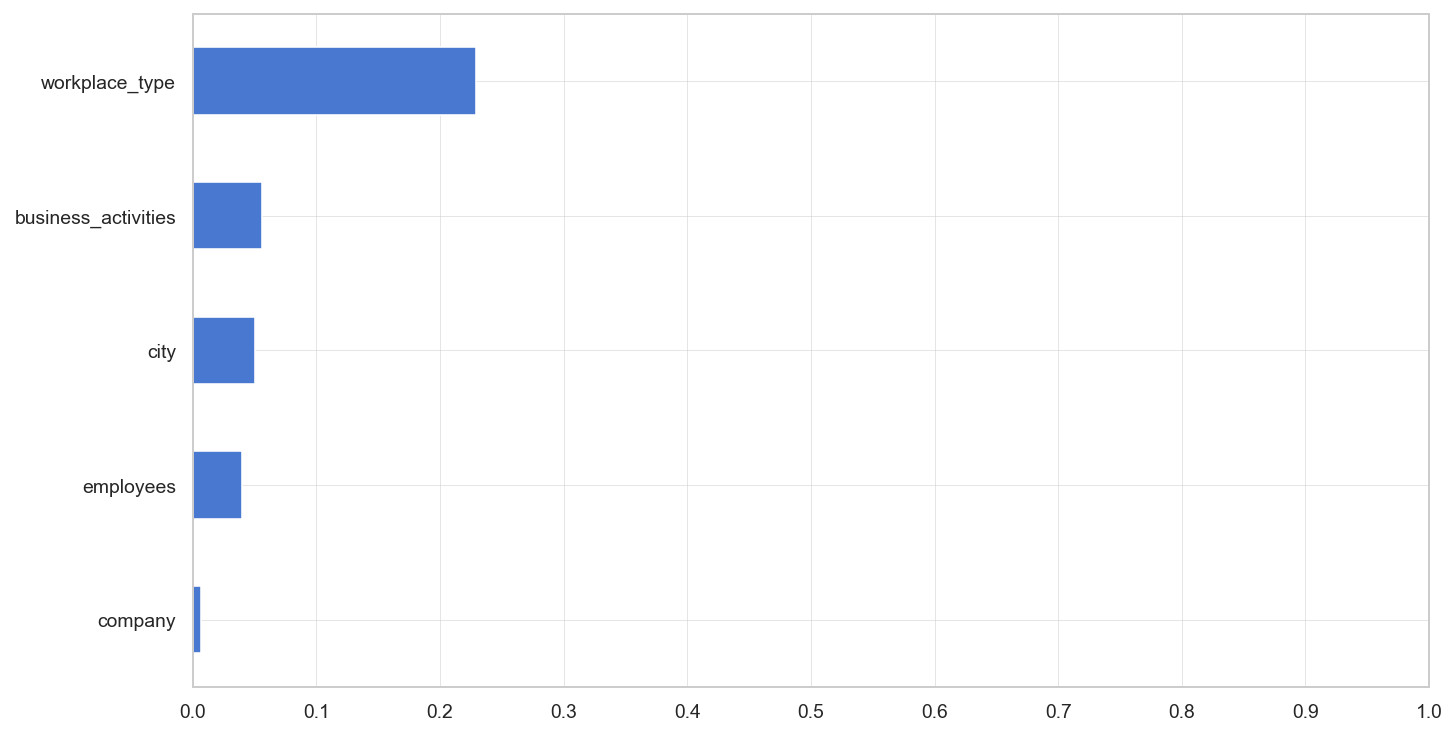

In [15]:
ready_data.isna().mean() \
    .sort_values().where(lambda x: x > 0).dropna() \
    .plot(kind='barh',
          figsize=(10, 3 + len(ready_data.columns) // 6),
          xlim=(0, 1),
          xticks=np.linspace(0, 1, 11));

Пять вакансий не имеют имени компании, по ссылкам ничего не открывается, поэтому удалим их.

In [16]:
print(ready_data.loc[ready_data.company.isna(), 'link'].values)
ready_data = ready_data[~ready_data.company.isna()]

['https://www.linkedin.com/jobs/view/3257384545/?eBP=JOB_SEARCH_ORGANIC&recommendedFlavor=ACTIVELY_HIRING_COMPANY&refId=QOFWrpfBlfQE4FMgeFNENg%3D%3D&trackingId=QBRnMij1TLKtpO8GEN6kQQ%3D%3D&trk=flagship3_search_srp_jobs'
 'https://www.linkedin.com/jobs/view/3237154761/?eBP=JOB_SEARCH_ORGANIC&refId=G2OxqGPsqJNpRzOopMCZgQ%3D%3D&trackingId=4CAE8wOjnj8%2FwPmN%2B5JT6w%3D%3D&trk=flagship3_search_srp_jobs'
 'https://www.linkedin.com/jobs/view/3255156403/?eBP=JOB_SEARCH_ORGANIC&refId=2Xi92RtfE%2BMLRpuqwevCHw%3D%3D&trackingId=mTKNmMJ0VAaKGdYJMgGtwg%3D%3D&trk=flagship3_search_srp_jobs'
 'https://www.linkedin.com/jobs/view/3260906256/?eBP=JOB_SEARCH_ORGANIC&refId=aWQXhT70%2Bx54RJEodr3qMw%3D%3D&trackingId=yefVGJfMxHwRR3Ueny7mYw%3D%3D&trk=flagship3_search_srp_jobs'
 'https://www.linkedin.com/jobs/view/3240789788/?eBP=JOB_SEARCH_ORGANIC&refId=TMQrFZc%2BlHel1sbZzDMIMQ%3D%3D&trackingId=8%2BsrxL0mUUv%2FvIkxI4cjAA%3D%3D&trk=flagship3_search_srp_jobs']


Пропуски в формате работы, сфере деятельности компании и городе заменим на None.
> Город не указан преимущественно у вакансий с удаленкой.

In [17]:
ready_data.loc[ready_data.city.isna(), 'workplace_type'].value_counts()

Remote    38
Name: workplace_type, dtype: int64

In [18]:
ready_data.loc[ready_data.business_activities.isna(), 'business_activities'] = \
    ready_data.loc[ready_data.business_activities.isna(), 'business_activities'].fillna('None')

ready_data.loc[ready_data.workplace_type.isna(), 'workplace_type'] = \
    ready_data.loc[ready_data.workplace_type.isna(), 'workplace_type'].fillna('None')

ready_data.loc[ready_data.city.isna(), 'city'] = \
    ready_data.loc[ready_data.city.isna(), 'city'].fillna('None')

Количество сотрудников заполним средним значением округленным до ближайшего из набора.

In [19]:
# В наборе есть два близких значения, заменим одно их них.
ready_data.loc[:, 'employees'] = \
    ready_data.loc[: 'employees'].replace({10001: 20000})

# Предположим что крупные компании всегда указывают число сотрудников.
a0 = ready_data.employees.where(ready_data.employees < 1000).mean()
a = ready_data.employees.unique()
a = a[~np.isnan(a)]
sorted(a)

[10.0, 50.0, 200.0, 500.0, 1000.0, 5000.0, 10000.0, 20000.0]

In [20]:
avg_employees = a.flat[np.abs(a - a0).argmin()]
avg_employees

200.0

In [21]:
ready_data.loc[ready_data.employees.isna(), 'employees'] = avg_employees

Разделим скилы по отдельным столбцам.

In [22]:
# Сохраним количество признаков до explode и get_dummies.
df_len = ready_data.shape[1]

# Агрегатор.
def agg_func(df, df_len=df_len):
    df_part_1 = df.iloc[0, :df_len]
    df_part_2 = df.iloc[:, df_len:].sum()
    return pd.concat([df_part_1, df_part_2])

# Иначе explode не сработает.
ready_data['skills'] = ready_data['skills'].apply(literal_eval)

# get_dummies позволяет получить 1-ки в том случае если в вакансии указан нужный скилл.
ready_data = pd.concat([ready_data,
                        pd.get_dummies(ready_data.explode('skills').skills)],
                       axis=1)

# Теперь группируем explode-датафрейм.
ready_data = ready_data.groupby(ready_data.index).apply(agg_func)

Ещё раз проверим число пропусков и выведем обработанный датафрейм.

In [23]:
ready_data.isna().sum().sum()

0

In [24]:
print(ready_data.shape, end='\n\n')
with pd.option_context('display.max_columns', None):
    display(ready_data.head())

(768, 93)



,title,company,employees,business_activities,workplace_type,placement_date,applicants,geo,city,country,description,skills,link,ai,cv,ml,r,a/b testing,adobe analytics,airflow,alteryx,apache spark,api,aws,azure,bigquery,c#,c++,computer vision,css,dashboard,data studio,databricks,dataiku,datastage,deep learning,docker,domo,erwin,excel,gcp,github,gitlab,google analytics,hadoop,hana,hive,html,informatica,java,jenkins,jira,julia,kantar,keras,linux,logstash,looker,lstm,matlab,metabase,microsoft sql,microstrategy,nlp,omniture,oracle data integrator,panorama,pentaho,postgresql,power bi,power point,python,qlik sense,qlikview,rapidminer,redshift,salesforce,sas,scala,snowflake,spark,spotfire,spss,sql,ssis,statistics,tableau,tensorflow,thoughtspot,timeseries,trello,vba,wfh
0,Data Scientist,La Fosse Associates,500.000,Staffing and Recruiting,Hybrid,2022-09-06,200,"London, England, United Kingdom",London,United Kingdom,🏦 Wealth Management Data Scientist Hybrid WFH...,"{ ml , python, power bi, sql, excel, wfh, nlp}",https://www.linkedin.com/jobs/view/3253822306/...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,Data Scientist,LMAX Group,500.000,Financial Services,On-site,2022-09-07,200,"London, England, United Kingdom",London,United Kingdom,"As a Data Scientist, you will play an integral...","{api, python, sql, excel, ssis}",https://www.linkedin.com/jobs/view/3257274065/...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,Data Scientist,MANGO,20000.000,Retail Apparel and Fashion,Hybrid,2022-09-06,200,"Palau-solità i Plegamans, Catalonia, Spain",Palau-solità i Plegamans,Spain,We are seeking a Data Scientist to join our Ad...,"{statistics, python, aws, azure, spark, comput...",https://www.linkedin.com/jobs/view/3249103731/...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,Data Scientist,Wipro Technologies,500.000,Business Consulting and Services,On-site,2022-09-05,200,"London, England, United Kingdom",London,United Kingdom,The role requires consultants who can help Wip...,"{api, tensorflow, python, excel, keras, deep l...",https://www.linkedin.com/jobs/view/3247845645/...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Data Scientist,Crunch Analytics,50.000,IT Services and IT Consulting,Hybrid,2022-09-07,200,Ghent Metropolitan Area,Ghent,Belgium,Eager to work on data-centric projects that ap...,"{statistics, python, dashboard, spark, excel, ...",https://www.linkedin.com/jobs/view/3256782698/...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


Проверка. Все признаки которые есть в skills также имеют единицу в соответствующих столбцах.

In [25]:
ready_data.loc[1, ready_data.loc[1, 'skills']]

api       1
python    1
sql       1
excel     1
ssis      1
Name: 1, dtype: object

Сохраним данные.

In [26]:
ready_data.to_csv('clean_data.csv', index=False)

# Вывод

* Получены данные вакансий Data Scientist'ов с LinkedIn.
* Создан соответствующий ТЗ датафрейм с нужными для визуализации признаками.